In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pathlib
import warnings

from sklearn.utils import shuffle, parallel_backend
from sklearn.exceptions import ConvergenceWarning
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
)
from joblib import load
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
# load training data from indexes and features dataframe
data_split_path = pathlib.Path(f"../0.split_data/indexes/data_split_indexes.tsv")
data_path = pathlib.Path("../../data/SHSY5Y_preprocessed_sc_norm.parquet")
# dataframe with only the labeled data we want (exclude certain phenotypic classes)
data_df = pq.read_table(data_path).to_pandas()
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)

# subset data_df by indexes in data_split_indexes
training_data = data_df.loc[data_split_indexes["labeled_data_index"]]

In [3]:
# read in toml file and get parameters
import toml

toml_path = pathlib.Path("../1.train_models/single_class_config.toml")
with open(toml_path, "r") as f:
    config = toml.load(f)
control = config["logistic_regression_params"]["control"]
treatment = config["logistic_regression_params"]["treatments"]

In [4]:
# get oneb_Metadata_Treatment_Dose_Inhibitor_Dose  =='DMSO_0.100_DMSO_0.025' and 'LPS_100.000_DMSO_0.025 and Thapsigargin_10.000_DMSO_0.025'
training_data = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [control, treatment]
    )
]

In [5]:
# at random downsample the DMSO treatment to match the number of wells in the LPS treatment
# get the number of wells in the LPS treatment
trt_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == treatment
].shape[0]
# get the number of wells in the DMSO treatment
dmso_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].shape[0]
# downsample the DMSO treatment to match the number of wells in the LPS treatment
dmso_holdout = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].sample(n=trt_wells)
# remove the downsampled DMSO wells from the data
training_data = training_data.drop(dmso_holdout.index)

In [6]:
# set model path from parameters
model_path = pathlib.Path(f"./models/single_class/{control}__{treatment}")

In [7]:
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP"]
phenotypic_classes = [training_data["Metadata_Treatment"].unique()[0]]

In [8]:
# define metadata columns
# subset each column that contains metadata
metadata = training_data.filter(regex="Metadata")
# drop all metadata columns
data_x = training_data.drop(metadata.columns, axis=1)
labeled_data = training_data["Metadata_Treatment"]

In [9]:
# set path for figures
figure_path = pathlib.Path(f"./figures/single_class/{control}__{treatment}")
figure_path.mkdir(parents=True, exist_ok=True)

final CP DMSO


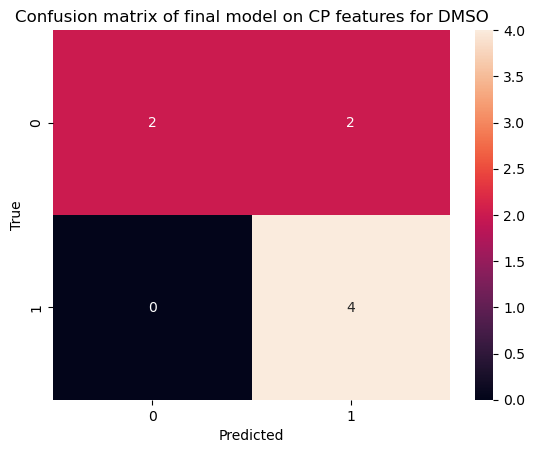

shuffled_baseline CP DMSO


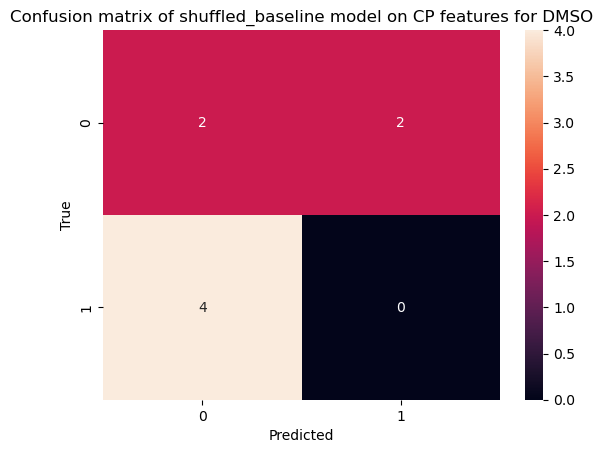

In [10]:
# test model on testing data
for model_type, feature_type, phenotypic_class in itertools.product(
    model_types, feature_types, phenotypic_classes
):
    print(model_type, feature_type, phenotypic_class)
    # load model
    model = load(f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib")

    # get predictions
    predictions = model.predict(data_x)

    # get probabilities

    probabilities = model.predict_proba(data_x)

    # get accuracy
    accuracy = accuracy_score(labeled_data, predictions)

    # get f1 score
    f1 = f1_score(labeled_data, predictions, average="weighted")

    # plot confusion matrix heatmap
    sns.heatmap(confusion_matrix(labeled_data, predictions), annot=True, fmt="g")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(
        f"Confusion matrix of {model_type} model on {feature_type} features for {phenotypic_class}"
    )
    plt.savefig(f"{figure_path}/{model_type}__{feature_type}__{phenotypic_class}.png")
    plt.show()